<a href="https://colab.research.google.com/github/osman160128/Ambulance/blob/main/Monte%20Carlo%20simulation%20on%203D%20shapes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

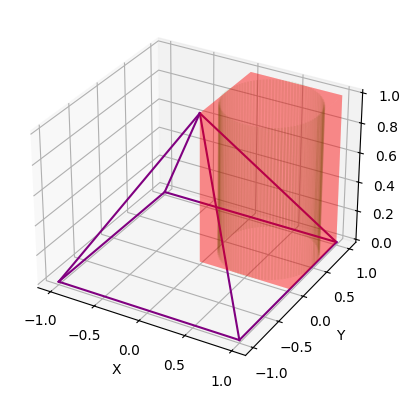

Box test: [True, True, True]
Cylinder test: [True, True, True]
Pyramid test: [True, True, True]
Estimated volume of intersection: 0.784683


In [1]:
import numpy as np
from multiprocessing import Pool
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Define the shapes
def is_inside_box(point, vertices):
    min_x = min(vertices[:, 0])
    max_x = max(vertices[:, 0])
    min_y = min(vertices[:, 1])
    max_y = max(vertices[:, 1])
    min_z = min(vertices[:, 2])
    max_z = max(vertices[:, 2])

    return min_x <= point[0] <= max_x and min_y <= point[1] <= max_y and min_z <= point[2] <= max_z

def is_inside_cylinder(point, c1, c2, radius):
    height_vector = c2 - c1
    height = np.linalg.norm(height_vector)
    axis = height_vector / height
    projection = np.dot(point - c1, axis)

    if projection < 0 or projection > height:
        return False

    perpendicular_vector = point - (c1 + projection * axis)
    distance = np.linalg.norm(perpendicular_vector)

    return distance <= radius

def is_inside_pyramid(point, vertices):
    apex = vertices[0]
    base_vertices = vertices[1:]

    if point[2] > apex[2]:
        return False

    base_min_x = min(base_vertices[:, 0])
    base_max_x = max(base_vertices[:, 0])
    base_min_y = min(base_vertices[:, 1])
    base_max_y = max(base_vertices[:, 1])

    if not (base_min_x <= point[0] <= base_max_x and base_min_y <= point[1] <= base_max_y):
        return False

    return True

def is_inside_all_shapes(point, box_vertices, cyl_c1, cyl_c2, cyl_radius, pyramid_vertices):
    return (is_inside_box(point, box_vertices) and
            is_inside_cylinder(point, cyl_c1, cyl_c2, cyl_radius) and
            is_inside_pyramid(point, pyramid_vertices))

def monte_carlo_estimation(num_points, box_vertices, cyl_c1, cyl_c2, cyl_radius, pyramid_vertices):
    bounding_box_min, bounding_box_max = calculate_bounding_box(box_vertices, cyl_c1, cyl_c2, cyl_radius, pyramid_vertices)
    points = np.random.rand(num_points, 3) * (bounding_box_max - bounding_box_min) + bounding_box_min

    with Pool() as pool:
        results = pool.starmap(is_inside_all_shapes, [(point, box_vertices, cyl_c1, cyl_c2, cyl_radius, pyramid_vertices) for point in points])

    volume_bounding_box = np.prod(bounding_box_max - bounding_box_min)
    volume_intersection = (sum(results) / num_points) * volume_bounding_box
    return volume_intersection

def calculate_bounding_box(box_vertices, cyl_c1, cyl_c2, cyl_radius, pyramid_vertices):
    all_points = np.vstack([box_vertices, cyl_c1, cyl_c2, pyramid_vertices])
    min_bounds = np.min(all_points, axis=0)
    max_bounds = np.max(all_points, axis=0)

    min_bounds -= cyl_radius
    max_bounds += cyl_radius

    return min_bounds, max_bounds

def plot_shapes(box_vertices, cyl_c1, cyl_c2, cyl_radius, pyramid_vertices, box_color=(0.1, 0.8, 0.11, 0.5), cyl_color='r', pyramid_color='b'):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the box with custom color
    box_edges = [
        [box_vertices[i] for i in [0, 1, 5, 4]],
        [box_vertices[i] for i in [1, 2, 6, 5]],
        [box_vertices[i] for i in [2, 3, 7, 6]],
        [box_vertices[i] for i in [3, 0, 4, 7]],
        [box_vertices[i] for i in [0, 1, 2, 3]],
        [box_vertices[i] for i in [4, 5, 6, 7]]
    ]
    for edge in box_edges:
        poly = Poly3DCollection([edge], alpha=0.25)
        poly.set_facecolor(box_color)  # Set the color for the box
        ax.add_collection3d(poly)

    # Plot the cylinder with custom color
    cyl_height = np.linalg.norm(cyl_c2 - cyl_c1)
    cyl_axis = (cyl_c2 - cyl_c1) / cyl_height
    theta = np.linspace(0, 2 * np.pi, 100)
    cyl_bottom = np.array([
        [cyl_c1[0] + cyl_radius * np.cos(t), cyl_c1[1] + cyl_radius * np.sin(t), cyl_c1[2]]
        for t in theta
    ])
    cyl_top = cyl_bottom + cyl_height * cyl_axis

    # Reshape Z coordinates for plot_surface
    cyl_bottom_x, cyl_bottom_y, cyl_bottom_z = cyl_bottom.T
    cyl_bottom_z = cyl_bottom_z.reshape((1, -1))
    cyl_top_x, cyl_top_y, cyl_top_z = cyl_top.T
    cyl_top_z = cyl_top_z.reshape((1, -1))

    ax.plot_surface(cyl_bottom_x, cyl_bottom_y, cyl_bottom_z, color=cyl_color, alpha=0.1)  # Set the color for the cylinder
    ax.plot_surface(cyl_top_x, cyl_top_y, cyl_top_z, color=cyl_color, alpha=0.1)  # Set the color for the cylinder
    for i in range(len(cyl_bottom)):
        ax.plot([cyl_bottom[i, 0], cyl_top[i, 0]], [cyl_bottom[i, 1], cyl_top[i, 1]], [cyl_bottom[i, 2], cyl_top[i, 2]], color=cyl_color, alpha=0.1)

    # Plot the pyramid with custom color
    pyramid_edges = [
        [pyramid_vertices[0], pyramid_vertices[i]] for i in range(1, 5)
    ] + [
        [pyramid_vertices[i], pyramid_vertices[i % 4 + 1]] for i in range(1, 5)
    ]
    for edge in pyramid_edges:
        ax.plot([edge[0][0], edge[1][0]], [edge[0][1], edge[1][1]], [edge[0][2], edge[1][2]], color=pyramid_color)  # Set the color for the pyramid

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

# Example usage
box_vertices = np.array([
    [0.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
    [1.0, 1.0, 0.0],
    [1.0, 0.0, 0.0],
    [0.0, 0.0, 1.0],
    [0.0, 1.0, 1.0],
    [1.0, 1.0, 1.0],
    [1.0, 0.0, 1.0]
])
cyl_c1 = np.array([0.5, 0.5, 1.0])
cyl_c2 = np.array([0.5, 0.5, 0.0])
cyl_radius = 0.5
pyramid_vertices = np.array([
    [0, 0, 1],
    [1, 1, 0],
    [-1, 1, 0],
    [-1, -1, 0],
    [1, -1, 0]
])

# Visualize the shapes with custom colors
plot_shapes(box_vertices, cyl_c1, cyl_c2, cyl_radius, pyramid_vertices, box_color=(1, 0, 0, 0.5), cyl_color='g', pyramid_color='purple')

# Test points
test_points = np.array([
    [0.5, 0.5, 0.5],  # Inside the box, the cylinder, and the pyramid
    [0.5, 0.5, 0.5],  # Inside the box, the cylinder, and the pyramid
    [0.5, 0.5, 0.5]   # Inside all shapes
])

# Test is_inside_box
print("Box test:", [is_inside_box(point, box_vertices) for point in test_points])

# Test is_inside_cylinder
print("Cylinder test:", [is_inside_cylinder(point, cyl_c1, cyl_c2, cyl_radius) for point in test_points])

# Test is_inside_pyramid
print("Pyramid test:", [is_inside_pyramid(point, pyramid_vertices) for point in test_points])

# Estimate the volume of intersection
volume = monte_carlo_estimation(10000000, box_vertices, cyl_c1, cyl_c2, cyl_radius, pyramid_vertices)
print(f"Estimated volume of intersection: {volume}")
